# Notebook2: Predicting CO2 emissions using Neural Networks

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [1]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Plot Functions

In [3]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation and Feature Selection

In [4]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [5]:
# Import data
trainset_df = pd.read_csv('Dataset2_train.csv')
testset_df = pd.read_csv('Dataset2_test.csv')






In [6]:
trainset_df

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,Vehicle Class_MID-SIZE,...,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z,CO2 Emissions(g/km),Make
0,4.0,6.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,299.0,NISSAN
1,2.4,4.0,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,193.0,HYUNDAI
2,2.0,4.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,221.0,BMW
3,2.5,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,212.0,TOYOTA
4,5.0,8.0,1.0,8.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,313.0,JAGUAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLKSWAGEN
7380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLKSWAGEN
7381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLVO
7382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOLVO


In [7]:
X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']

In [8]:
X_test

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,Vehicle Class_MID-SIZE,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,6.2,8.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.6,6.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.2,8.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2.0,4.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.8,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Setup pipline for Standardisation

In [9]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [10]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [11]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0        0.612690   0.200638     -1.602571             1.0   
1       -0.567895  -0.889172     -0.750938             1.0   
2       -0.863042  -0.889172      0.952329             1.0   
3       -0.494109  -0.889172     -0.750938             1.0   
4        1.350555   1.290448      0.952329             1.0   

   Model Features_Flexible-fuel vehicle  Model Features_Four-wheel drive  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3                                   0.0                              0.0   
4                                   0.0                              0.0   

   Model Features_Long wheelbase  Model Features_Short wheelbase  \
0                            0.0                             0.0   
1        

In [12]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_Loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)



## 3 W&B Grid Search to Find Best NN Parameter Set

In [13]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\87383\_netrc
wandb: Currently logged in as: yixuan228 (yixuan228-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Neural Network Structure

In [14]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [15]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [16]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [17]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [18]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage2', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        val_loss = val_epoch(model, val_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Training complete for all configurations.


Visualization of each Search

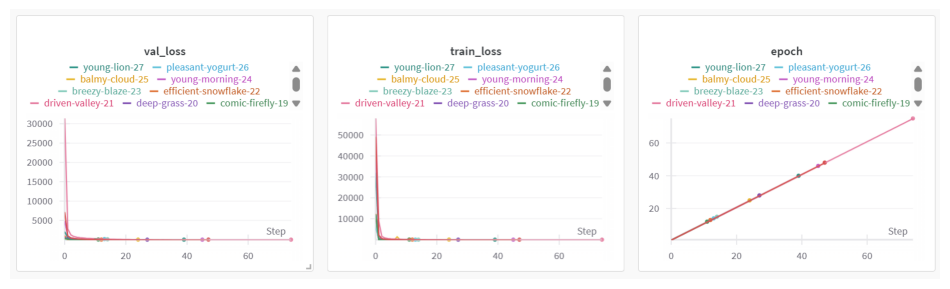

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "S1_NN_loss.png"
img = mpimg.imread(image_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [20]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

### Save all the model config

In [21]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


### Select the best model

In [22]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")



Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


## Conclusion

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 118\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094


